### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

["antidepressants free U.S???I'm México antidepressants cheap plus bought recipe Anyways going psychiatrist prescribed medicine anxiety miraculous felt good life course going psychotherapist wondering expensive U.S cause México cheap know suffering long cure right pretty solid price",
 'buddys dad got fired wanted teach online friends dad fired teaching Nd job told teach class online needed large family immunocompromised covid huge risk petitioners set help job single person help greatly appreciated https://www.change.org/p/ltisd-administrators-save-schmidt',
 'Attempted SuicideLast week decided 5000 mg 5 Grams Zoloft 20 mg Klonopin took hesitant found weird time attempting suicide hesitant scared time calm scared surprised wake find alive thought dosage kill read people overdose died took know use think commit suicide attempt proven wrong time bit scared fear kept alive fear gone feels like life movement hesitation ER ended vomiting sleeping recall vomiting sleeping effects overdosing

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

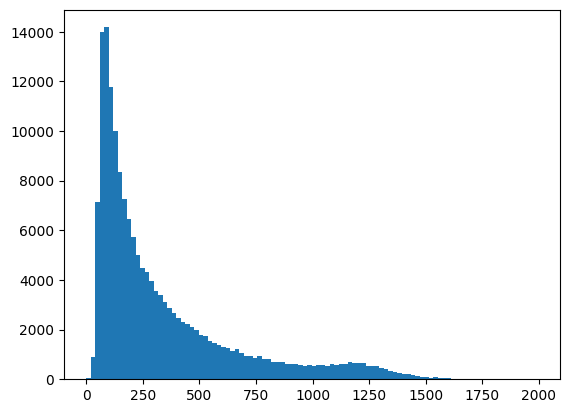

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [8]:
vectorized_texts = vectorize_layer(processed_texts)

In [9]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [10]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 180s 34ms/step - accuracy: 0.9013 - loss: 0.2451 - val_accuracy: 0.9354 - val_loss: 0.1765
Epoch 2/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 176s 34ms/step - accuracy: 0.9417 - loss: 0.1569 - val_accuracy: 0.9354 - val_loss: 0.1715
Epoch 3/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 179s 34ms/step - accuracy: 0.9451 - loss: 0.1479 - val_accuracy: 0.9398 - val_loss: 0.1613
Epoch 4/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 176s 34ms/step - accuracy: 0.9488 - loss: 0.1388 - val_accuracy: 0.9419 - val_loss: 0.1562
Epoch 5/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 178s 34ms/step - accuracy: 0.9513 - loss: 0.1307 - val_accuracy: 0.9410 - val_loss: 0.1578
Epoch 6/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 179s 34ms/step - accuracy: 0.9543 - loss: 0.1239 - val_accuracy: 0.9415 - val_loss: 0.1637
Epoch 7/10
5229/5229 ━━━━━━━━━━━━━━━━━━━━ 177s 34ms/step - accuracy: 0.9574 - loss: 0.1141 - val_accuracy: 0.9395 - val_loss: 0.1632


##### Evaluating the Model

In [12]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [13]:
best_model = model
with open('../models/lstm_bi_last.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [14]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 40)        │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,213 (746.93 KB)

 Trainable params: 63,737 (248.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,476 (497.96 KB)

589/589 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9571 - loss: 0.1201


In [15]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

589/589 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0450
False Negative Rate: 0.0378
accuracy_score 0.959
precision_score 0.966
recall_score 0.962
f1_score 0.964


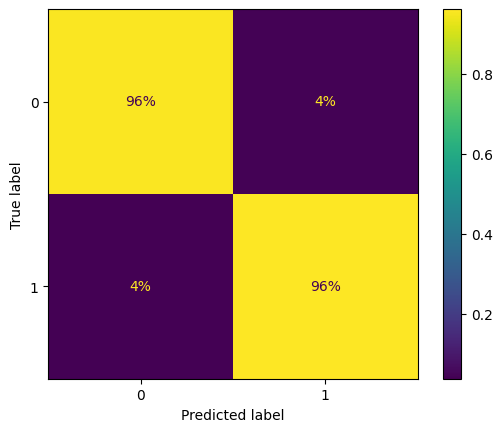

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()